In [1]:
import sys
print(sys.executable)


d:\python Practice\exercise-counter\venv310\Scripts\python.exe


In [1]:
import mediapipe as mp
print(mp.__version__)


0.10.10


In [2]:
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from pose_detector import PoseDetector
from counter import SquatCounter, PushupCounter, PullupCounter, CrunchCounter
from utils import calculate_angle


In [3]:
mode = input("Select exercise (s = squat, p = pushup, l = pullup, c = crunch): ").lower()
#mode="p"
if mode == "s":
    counter = SquatCounter()
    joint_ids = (24, 26, 28)  # hip, knee, ankle
    exercise_name = "Squats"

elif mode == "p":
    counter = PushupCounter()
    joint_ids = (12, 14, 16)  # shoulder, elbow, wrist
    exercise_name = "Pushups"

elif mode == "l":
    counter = PullupCounter()
    joint_ids = (12, 14, 16)  # shoulder, elbow, wrist
    exercise_name = "Pullups"

elif mode == "c":
    counter = CrunchCounter()
    joint_ids = (12, 24, 26)  # shoulder, hip, knee
    exercise_name = "Crunchs"
else:
    raise ValueError("Invalid mode. Use 's' or 'p' or 'l' or 'c'.")


In [4]:
VIDEO_IN = Path("D:\python Practice\exercise-counter\data\istockphoto-1309273813-640_adpp_is.mp4")
VIDEO_OUT = Path("../results/annotated_video_cn.mp4")
CSV_OUT = Path("../results/reps_cn.csv")
PLOT_OUT = Path("../results/angle_plot_cn.png")

# Make sure these exist
assert VIDEO_IN.exists(), "Input video not found"

# Initialize pose model 
pose = PoseDetector()



In [7]:
from IPython.display import Video

Video(VIDEO_IN, embed=True)


In [5]:
cap = cv2.VideoCapture(str(VIDEO_IN))

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

writer = cv2.VideoWriter(
    str(VIDEO_OUT),
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
)


In [ ]:
#RIGHT_HIP = 24
#RIGHT_KNEE = 26
#RIGHT_ANKLE = 28


In [6]:
frame_idx = 0
records = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = pose.detect(frame)  

    angle = None

    if results.pose_landmarks:
        lm = results.pose_landmarks.landmark

        p1 = lm[joint_ids[0]]
        p2 = lm[joint_ids[1]]
        p3 = lm[joint_ids[2]]

        pt1 = [p1.x * width, p1.y * height]
        pt2 = [p2.x * width, p2.y * height]
        pt3 = [p3.x * width, p3.y * height]

        angle = calculate_angle(pt1, pt2, pt3)
        counter.update(angle)


        # Draw knee angle
        cv2.putText(
            frame,
            f"Angle: {int(angle)}",
            (int(pt2[0]), int(pt2[1]-15)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
        )

        # Draw joints
        for p in [p1, p2, p3]:
            cv2.circle(frame, (int(p.x*width), int(p.y*height)), 6, (0,0,255), -1)

    # Squat counter overlay
    cv2.rectangle(frame, (0,0), (260,80), (0,0,0), -1)
    cv2.putText(
        frame,
        f"{exercise_name}: {counter.count}",
        (10,55),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0,255,255),
        3,
    )

    writer.write(frame)

    # Save data
    records.append({"frame": frame_idx, "angle": angle, "count": counter.count})
    frame_idx += 1


In [7]:
cap.release()
writer.release()
pose.close()


In [8]:
df = pd.DataFrame(records)
df.to_csv(CSV_OUT, index=False)
df.head(20)


,frame,angle,count
0,0,117.045862,0
1,1,115.926402,0
2,2,106.772235,0
3,3,99.261078,0
4,4,90.420639,0
5,5,82.289968,0
6,6,72.197611,0
7,7,58.668448,1
8,8,48.079940,1
9,9,42.180197,1


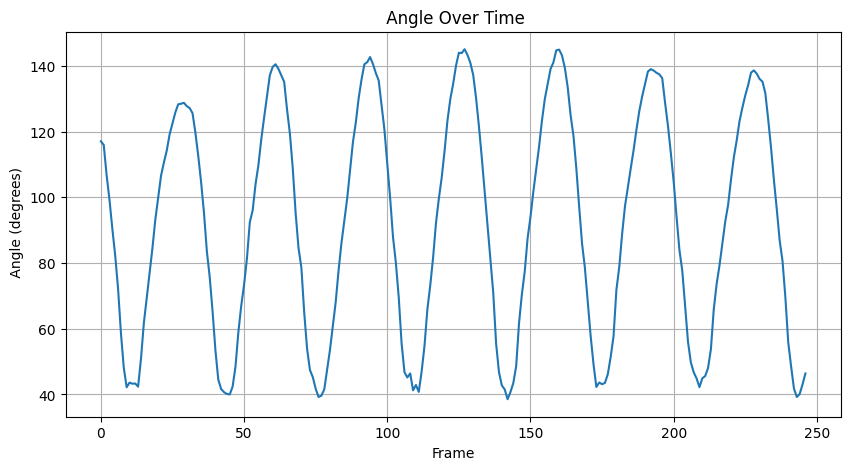

In [9]:
plt.figure(figsize=(10,5))
plt.plot(df["frame"], df["angle"])
plt.xlabel("Frame")
plt.ylabel(" Angle (degrees)")
plt.title(" Angle Over Time")
plt.grid(True)
plt.savefig(PLOT_OUT)
plt.show()


In [10]:
print(f"Total exercise in the video: {counter.count}")


Total exercise in the video: 8


In [24]:
from IPython.display import Video

Video(str(VIDEO_OUT))


In [11]:
import cv2

cap = cv2.VideoCapture(str(VIDEO_OUT))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Annotated Video", frame)

    # Press 'q' to exit
    if cv2.waitKey(25) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
